In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import AutoMinorLocator

import utils

%matplotlib inline

plt.style.use('/mnt/home/tnguyen/default.mplstyle')

### Read data

In [2]:
model_name = 'gru-gru-opt-ratio'
data_root = "/mnt/ceph/users/tnguyen/florah-tree/sc-sam/gureft90-nprog3-dt4-z15/"
sim_table = utils.read_all_props(os.path.join(data_root, 'sim/output'))
gen_table = utils.read_all_props(os.path.join(data_root, f'{model_name}/output'))
sat_types = [0, 1, 2, 3]

select = (sim_table['mstar'] > 0) & np.isin(sim_table['sat_type'], sat_types)
sim_table = sim_table[select]
select = (gen_table['mstar'] > 0) & np.isin(gen_table['sat_type'], sat_types)
gen_table = gen_table[select]

plotdir = f'/mnt/home/tnguyen/projects/florah/figures/sc-sam/gureft90-{model_name}'
os.makedirs(plotdir, exist_ok=True)

In [3]:
mhalo_bins = np.arange(5.5, 12.5, 0.25)
mhalo_bins_ce = 0.5 * (mhalo_bins[1:] + mhalo_bins[:-1])
num_bins = len(mhalo_bins) - 1
q = [50, 16, 84]
min_count = 10

In [4]:
sim_log_mcold = np.log10(sim_table['mcold'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mcold = np.log10(gen_table['mcold'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9
min_log_mcold = 4.1

sim_log_mcold_q = np.zeros((num_bins, len(q)))
gen_log_mcold_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > mhalo_bins[i]) & (sim_log_mhalo < mhalo_bins[i+1])
    select &= sim_log_mcold > min_log_mcold
    if select.sum() < min_count:
        sim_log_mcold_q[i] = np.nan
    else:
        sim_log_mcold_q[i] = np.nanpercentile(sim_log_mcold[select], q)

    select = (gen_log_mhalo > mhalo_bins[i]) & (gen_log_mhalo < mhalo_bins[i+1])
    select &= gen_log_mcold > min_log_mcold
    if select.sum() < min_count:
        gen_log_mcold_q[i] = np.nan
    else:
        gen_log_mcold_q[i] = np.nanpercentile(gen_log_mcold[select], q)

/tmp/ipykernel_3474654/3282221144.py:1: RuntimeWarning: divide by zero encountered in log10
  sim_log_mcold = np.log10(sim_table['mcold'].to_numpy()) + 9
/tmp/ipykernel_3474654/3282221144.py:3: RuntimeWarning: divide by zero encountered in log10
  gen_log_mcold = np.log10(gen_table['mcold'].to_numpy()) + 9


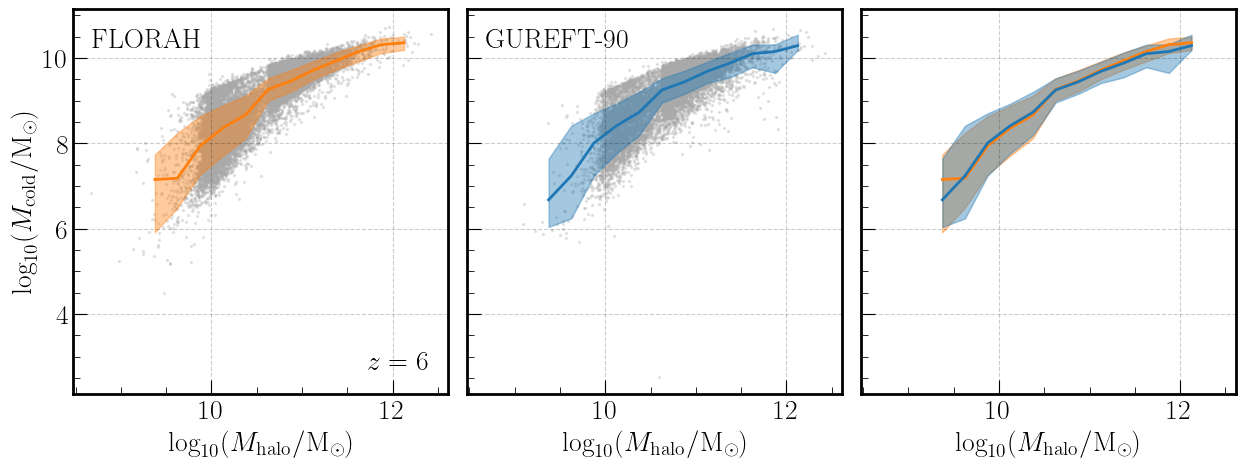

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_label = r'FLORAH'
sim_label = r'GUREFT-90'
gen_color = 'C1'
sim_color = 'C0'
xlim = (9, 12.5)
ylim = (5, None)

xlim = (None, None)
ylim = (None, None)
sc_alpha = 0.25

# plot only the generated galaxies
axes[0].scatter(gen_log_mhalo, gen_log_mcold, s=2, alpha=sc_alpha, color='darkgrey')
axes[0].plot(
    mhalo_bins_ce, gen_log_mcold_q[:, 0], color=gen_color, lw=2)
axes[0].fill_between(
    mhalo_bins_ce, gen_log_mcold_q[:, 1], gen_log_mcold_q[:, 2],
    alpha=0.4, color=gen_color)
axes[1].scatter(sim_log_mhalo, sim_log_mcold, s=2, alpha=sc_alpha, color='darkgrey')
axes[1].plot(
    mhalo_bins_ce, sim_log_mcold_q[:, 0], color=sim_color, lw=2)
axes[1].fill_between(
    mhalo_bins_ce, sim_log_mcold_q[:, 1], sim_log_mcold_q[:, 2],
    alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    mhalo_bins_ce, gen_log_mcold_q[:, 0], color=gen_color, lw=2)
axes[2].fill_between(
    mhalo_bins_ce, gen_log_mcold_q[:, 1], gen_log_mcold_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    mhalo_bins_ce, sim_log_mcold_q[:, 0], color=sim_color, lw=2)
axes[2].fill_between(
    mhalo_bins_ce, sim_log_mcold_q[:, 1], sim_log_mcold_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\rm cold}/ \rm M_{\odot})$')
for ax in axes:
    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/ \rm M_{\odot})$')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, gen_label,
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, sim_label,
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z=6$',
    transform=axes[0].transAxes, ha='right', va='bottom')

fig.subplots_adjust(wspace=0.05)
fig.savefig(os.path.join(plotdir, 'mcold_halo.png'), bbox_inches='tight', dpi=300)
plt.show()